In [56]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from math import *
from heapq import nlargest
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pickle

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA

from surprise import Dataset, Reader, SVD, accuracy, dump
from surprise.model_selection import GridSearchCV, cross_validate, train_test_split

# Import des modules contenant les fonctions utilitaires
import src.helpers as helpers

In [121]:
# Réglage des graphiques

plt.style.use('seaborn-whitegrid')

plt.rc('font', size=14)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=18)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('legend', fontsize=14)

dims_fig = (20,12)

# **Modélisation**

Je vais développer des modèles afin de suggérer des articles à lire aux utilisateurs du jeu de données.

In [58]:
data_path = 'data/articles/'
clicks_path = data_path + 'clicks/'

In [59]:
articles_df = pd.read_csv(data_path + 'articles_metadata.csv')
articles_df.head()

,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,1513144419000,0,168
1,1,1,1405341936000,0,189
2,2,1,1408667706000,0,250
3,3,1,1408468313000,0,230
4,4,1,1407071171000,0,162


In [60]:
articles_emb = pd.read_pickle(data_path + 'articles_embeddings.pickle')
articles_emb = pd.DataFrame(articles_emb, columns=["embedding_" + str(i) for i in range(articles_emb.shape[1])])
articles_emb.head()

,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,...,embedding_240,embedding_241,embedding_242,embedding_243,embedding_244,embedding_245,embedding_246,embedding_247,embedding_248,embedding_249
0,-0.161183,-0.957233,-0.137944,0.050855,0.830055,0.901365,-0.335148,-0.559561,-0.500603,0.165183,...,0.321248,0.313999,0.636412,0.169179,0.540524,-0.813182,0.286870,-0.231686,0.597416,0.409623
1,-0.523216,-0.974058,0.738608,0.155234,0.626294,0.485297,-0.715657,-0.897996,-0.359747,0.398246,...,-0.487843,0.823124,0.412688,-0.338654,0.320787,0.588643,-0.594137,0.182828,0.397090,-0.834364
2,-0.619619,-0.972960,-0.207360,-0.128861,0.044748,-0.387535,-0.730477,-0.066126,-0.754899,-0.242004,...,0.454756,0.473184,0.377866,-0.863887,-0.383365,0.137721,-0.810877,-0.447580,0.805932,-0.285284
3,-0.740843,-0.975749,0.391698,0.641738,-0.268645,0.191745,-0.825593,-0.710591,-0.040099,-0.110514,...,0.271535,0.036040,0.480029,-0.763173,0.022627,0.565165,-0.910286,-0.537838,0.243541,-0.885329
4,-0.279052,-0.972315,0.685374,0.113056,0.238315,0.271913,-0.568816,0.341194,-0.600554,-0.125644,...,0.238286,0.809268,0.427521,-0.615932,-0.503697,0.614450,-0.917760,-0.424061,0.185484,-0.580292


Le fichier articles_embedding sera uploadé sur Azure Blob Storage afin d'être utilisé par ma fonction Azure Function. Le fichier fait actuellement 355Mo, il est trop volumineux pour une utilisation dans le Cloud, il faut donc réduir sa taille.

Pour cela, je vais appliquer un ACP sur le fichier articles_embedding et le sauvegarder afin de réduire sa taille.

L'ACP permet de passer de 250 features à 70, et de garder une variance de 0.977

In [61]:
pca = PCA(n_components=70)
pca.fit(articles_emb)
articles_emb_trans_pca = pca.transform(articles_emb)

In [62]:
articles_emb_trans_pca = pd.DataFrame(articles_emb_trans_pca, columns=["embedding_" + str(i) for i in range(articles_emb_trans_pca.shape[1])])
articles_emb_trans_pca.head()

,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,...,embedding_60,embedding_61,embedding_62,embedding_63,embedding_64,embedding_65,embedding_66,embedding_67,embedding_68,embedding_69
0,-2.176780,-1.316911,-1.029057,0.901904,-1.809557,2.064691,1.221919,0.024455,0.927230,0.669837,...,0.230688,-0.100651,0.048138,0.056957,-0.320371,0.525809,0.113779,-0.419693,-0.002149,0.059550
1,-1.735179,0.489888,3.268564,0.087863,1.473049,0.932732,-1.841618,0.881803,-0.207214,-0.816813,...,-0.102199,0.083837,-0.035931,0.420113,0.301702,-0.111264,-0.144043,0.199322,-0.178389,0.083717
2,-0.912692,-2.089344,1.865870,-1.202513,2.530591,0.521986,-0.224344,-1.479936,-0.191824,-1.356810,...,0.105034,0.102360,0.192835,0.218498,0.142645,-0.139014,0.145816,-0.139328,0.066279,0.273961
3,1.096564,0.212949,4.183519,-0.649563,-0.130864,-1.126547,-1.063995,0.662898,0.348140,-1.463898,...,0.180002,-0.028677,-0.371331,-0.105213,0.366508,0.296257,0.351647,-0.043016,-0.055215,-0.296103
4,0.193782,-0.263953,1.896588,-1.834343,1.270362,1.723300,-0.328995,-0.283811,-0.659781,-1.223753,...,0.448671,-0.348889,0.222998,-0.082174,0.406044,-0.120856,0.379735,0.107040,0.157088,-0.132568


In [63]:
sum(pca.explained_variance_ratio_)

0.9773072160918661

In [64]:
clicks_df = helpers.get_all_clicks_files(clicks_path)
clicks_df = clicks_df[['user_id', 'session_id', 'session_size', 'click_article_id']]
clicks_df.head()

,user_id,session_id,session_size,click_article_id
0,0,1506825423271737,2,157541
1,0,1506825423271737,2,68866
2,1,1506825426267738,2,235840
3,1,1506825426267738,2,96663
4,2,1506825435299739,2,119592


In [65]:
users_df = clicks_df.groupby('user_id').agg({'click_article_id':lambda x: list(x)})
users_df.head()

,click_article_id
user_id,
0,"[157541, 68866, 96755, 313996, 160158, 233470,..."
1,"[235840, 96663, 59758, 160474, 285719, 156723,..."
2,"[119592, 30970, 30760, 209122]"
3,"[236065, 236294, 234686, 233769, 235665, 23513..."
4,"[48915, 44488, 195887, 195084, 63307, 336499, ..."


In [66]:
# Sauvegarde des fichiers pour le stockage Azure Blob
data_azure = 'data_azure'

list_dir = os.listdir('data/')

if data_azure not in list_dir:
    os.mkdir('data/' + data_azure)

articles_emb_trans_pca.to_pickle('data/' + data_azure + '/articles_embeddings.pickle')
clicks_df.to_pickle('data/' + data_azure + '/all_clicks.pickle')
users_df.to_pickle('data/' + data_azure + '/users.pickle')

### Content-Based Recommender model

Le premier modèle de recommandation est basé sur le **Content-Based**.

Ce modèle se base sur les préférences de l'utilisateur, en trouvant des articles équivalents aux articles qu'il a déjà lu.

In [67]:
def contentBasedRecommendArticle(articles, clicks, user_id, n=5):

    articles_read = clicks[clicks['user_id'] == user_id]['click_article_id'].tolist()

    if len(articles_read) == 0:
        return "L'utilisateur n'a lu aucun article"

    articles_read_embedding = articles.loc[articles_read]

    articles = articles.drop(articles_read)

    matrix = cosine_similarity(articles_read_embedding, articles)

    rec = []

    for i in range(n):
        coord_x = floor(np.argmax(matrix)/matrix.shape[1])
        coord_y = np.argmax(matrix)%matrix.shape[1]

        rec.append(int(articles.index[coord_y]))

        matrix[coord_x][coord_y] = 0

    return rec

In [68]:
# Avec le fichier d'embedding classique
test_cb = contentBasedRecommendArticle(articles_emb, clicks_df, 5)
print(test_cb)

[157015, 284603, 62627, 62630, 224354]


In [69]:
# Avec le fichier d'embedding réduit après l'ACP
test_cb_acp = contentBasedRecommendArticle(articles_emb_trans_pca, clicks_df, 5)
print(test_cb_acp)

[157015, 284603, 62627, 62630, 224354]


Le modèle utilise le calcul du cosinus entre les articles lus par l'utilisateur et les autres articles, qui sont projetés via leurs features de la matrice d'embedding dans un espace vectoriel.

La recommandation retourne n articles les plus similaies (n = 5 ici)

On voit qu'utiliser le fichier réduit après ACP ne change pas le résultat.

### Collaborative Filtering Recommender model

Le second modèle de recommandation est basé sur le **Collaborative-Filtering**.

Ce modèle se base sur les articles lus par l'utilisateur, et les préférences des autres utilisateurs ayant lus les mêmes articles.

C'est déterminer ce qu'un utilisateur pourrait aimer lire en croisant ses lectures avec les lectures des autres utilisateurs.

In [70]:
def calculRatingByClick(clicks):

    count_user_article_size = (clicks.groupby(['user_id', "click_article_id"]).agg(user_article_size=("session_size", "sum")))
    count_user_total_size = (clicks.groupby(['user_id']).agg(user_total_size=("session_size", "sum")))

    ratings = count_user_article_size.join(count_user_total_size, on="user_id")

    ratings['rating'] = ratings['user_article_size'] / ratings['user_total_size']

    ratings = ratings.reset_index().drop(['user_article_size', 'user_total_size'], axis = 1).rename({'click_article_id': 'article_id'}, axis = 1)

    return ratings

J'utilise le modèle SVD de la librairie surprise, qui prend un data contenant 3 colonnes :
- l'id du user
- l'id de l'article
- un "rating" qui correspond ici au ratio nombre de cliques sur l'article par rapport au nombre de cliques total du user

In [71]:
ratings = calculRatingByClick(clicks_df)

ratings.head()

,user_id,article_id,rating
0,0,68866,0.125
1,0,87205,0.125
2,0,87224,0.125
3,0,96755,0.125
4,0,157541,0.125


##### Recherche des meilleurs paramètres

In [72]:
reader = Reader(rating_scale=(0, 1))

data = Dataset.load_from_df(ratings.sample(frac=0.1, random_state=42), reader=reader)

param_grid = {'n_factors': [20, 50, 100], 'n_epochs': [10, 20, 50],
              'lr_all': [0.002, 0.005, 0.01], 'reg_all': [0.02, 0.04, 0.1]}

gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(data)

In [73]:
# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.11422937912415008
{'n_factors': 20, 'n_epochs': 50, 'lr_all': 0.01, 'reg_all': 0.1}


In [74]:
data = Dataset.load_from_df(ratings, reader=reader)

trainset = data.build_full_trainset()

model_SVD = gs.best_estimator['rmse']

model_SVD.fit(trainset)

In [75]:
# Sauvegarde du modèle
data_model = 'model'
model_filename = "model_svd.pickle"

list_dir = os.listdir('data/')

if data_model not in list_dir:
    os.mkdir('data/' + data_model)

dump.dump('data/' + data_model + '/' + model_filename, algo=model_SVD)

In [76]:
model_SVD.predict(5, 158536, verbose=True)

user: 5          item: 158536     r_ui = None   est = 0.03   {'was_impossible': False}


Prediction(uid=5, iid=158536, r_ui=None, est=0.029217198685950484, details={'was_impossible': False})

La prédiction retourne un score à partir d'un id de user et un id d'article.

Plus correpond potentiellement au "rating" de l'article pour le user en question.

Pour un user on va donc calculer ce score pour chaque article et retourner les plus élevés.

In [77]:
def collaborativeFilteringRecommendArticle(articles, clicks, user_id, n=5):

    index = list(articles.index)

    articles_read = clicks[clicks['user_id'] == user_id]['click_article_id'].tolist()

    for ele in articles_read:
        if ele in index:
            index.remove(ele)

    results = dict()

    for i in index:
        pred = model_SVD.predict(user_id, i)
        results[pred.iid] = pred.est
    
    return nlargest(n, results, key = results.get)

In [78]:
test_cf = collaborativeFilteringRecommendArticle(articles_emb, clicks_df, 5, 5)
print(test_cf)

[289003, 50644, 39894, 74501, 36162]


In [82]:
test_cf = collaborativeFilteringRecommendArticle(articles_emb, clicks_df, 120, 5)
print(test_cf)

[277107, 74501, 50644, 36162, 352979]


In [80]:
test_cf = collaborativeFilteringRecommendArticle(articles_emb, clicks_df, 850, 5)
print(test_cf)

[283009, 277107, 50644, 39894, 352979]


In [81]:
test_cf = collaborativeFilteringRecommendArticle(articles_emb, clicks_df, 45000, 5)
print(test_cf)

[289003, 283009, 74455, 277107, 50644]


On voit que certains articles sont régulièrement recommandés.

In [125]:
nb_clicks = clicks_df.groupby('click_article_id').agg({'user_id': 'count'}).rename(columns={'user_id': 'nb_clicks'}).reset_index()
nb_clicks = nb_clicks.sort_values(by='nb_clicks', ascending=False)
nb_clicks = nb_clicks.head(50)

<AxesSubplot:xlabel='click_article_id'>

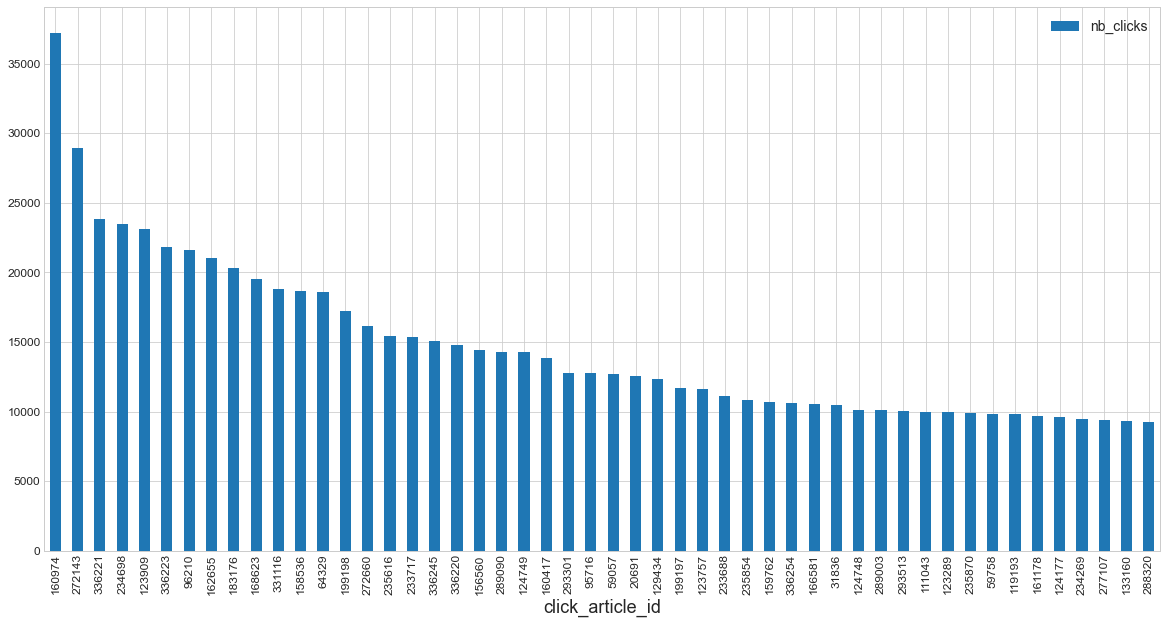

In [126]:
nb_clicks.plot.bar(x='click_article_id', y='nb_clicks', figsize=(20, 10))

Les articles souvent recommandés sont en fait des articles lus par beaucoup d'utilisateurs.